# Feature Selection

**Feature selection** can be an important part of model selection. In supervised learning, including features in a model which do not provide information on the label, is useless at best, and may prevent generalization at worst.

Feature selection can involve application of several methods. Two important methods include:
1. Eliminating features with **low variance** and **zero variance**. Zero variance features are comprised of the same values. Low variance features arise from features with most values the same and with few unique values. One way low variance features can arise, is from dummy variables for categories with very few members. The dummy variable will be mostly 0s with very few 1s. 
2. Training machine learning models with features that are **uninformative** can create a variety of problems. An uninformative feature does not significantly improve model performance. In many cases, the noise in the uninformative features will increase the variance of the model predictions. In other words, uninformative models are likely to reduce the ability of the machine learning model to generalize.   

****
**Note:** the second case of feature selection involves applying a selection statistic or hypothesis test multiple times. For large number of features, this process is very likely to lead to false positive and false negative results. This likely outcome is known as the **multiple comparison problem** in statistics.

To understand this problem, consider the decision to keep a feature in a model as a hypothesis test. Any hypothesis test has some probability of both a false positive result and a false negative result. Consider a case where there are 40 uninformative features which are excluded from the model with 95% confidence. There will be an approximately 5% chance of accepting a feature which should be rejected. In this case we would expect about 2 uninformative features to be accepted because of these errors. 

You may well ask, if testing features for importance can fail with large numbers of features, what is the alternative? The most general and scalable alternative is to use regularization methods. Consider applying regularization methods to a linear model. In this case, the machine learning algorithm learns which features should be weighted highly and which should not. 
****

## Load the dataset

You will now apply the aforementioned principles to the bank credit data set. 

As a first step, run the code in the cell below to load the required packages. 

> **Note:** If you are running in Azure Notebooks, make sure that you run the code in the `setup.ipynb` notebook at the start of you session to ensure your environment is correctly configured. 

In [1]:
## Import packages
library(ggplot2)
library(repr)
library(dplyr)
library(caret)
library(MASS)

options(repr.plot.width=4, repr.plot.height=4) # Set the initial plot area dimensions


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select



Next, load the preprocessed files containing the features and the labels. The preprocessing includes the following:
1. Clean missing values.
2. Aggregate categories of certain categorical variables. 

Execute the code in the cell below to load the data frame and remove some unneeded columns. 

In [2]:
credit = read.csv('German_Credit_Preped.csv')
credit[,'Customer_ID'] = NULL
dim(credit)
names(credit)

[1] 1000   21

[1] "checking_account_status"  "loan_duration_mo"        
 [3] "credit_history"           "purpose"                 
 [5] "loan_amount"              "savings_account_balance" 
 [7] "time_employed_yrs"        "payment_pcnt_income"     
 [9] "gender_status"            "other_signators"         
[11] "time_in_residence"        "property"                
[13] "age_yrs"                  "other_credit_outstanding"
[15] "home_ownership"           "number_loans"            
[17] "job_category"             "dependents"              
[19] "telephone"                "foreign_worker"          
[21] "bad_credit"

## Code the label

The R Caret package computes most performance metrics using the positive cases. For example, recall is a measure of correct classification of positive cases. Therefore, it is important to have the coding of the label correct. In this case you want to detect bad credit customers, so this category becomes the positive case. The code in the cell below creates a factor (categorical) variable and coerces the levels of the label column, `bad_credit`. Execute this code. 

In [3]:
credit$bad_credit <- ifelse(credit$bad_credit == 1, 'bad', 'good')
credit$bad_credit <- factor(credit$bad_credit, levels = c('bad', 'good'))
credit$bad_credit[1:5]

[1] good bad  good good bad 
Levels: bad good

## Scale numeric features

Cross validation is used in this notebook. Therefore, the code in the cell below scales the numeric features in batch, before any splits. This is done to simplify the processing for the CV folds. Execute this code. 

****
**Note:** Cross validation is discussed in another lab.
****

In [4]:
num_cols = c('loan_duration_mo', 'loan_amount', 'payment_pcnt_income', 'age_yrs', 'number_loans', 'dependents')
preProcValues <- preProcess(credit[,num_cols], method = c("center", "scale"))
credit[,num_cols] = predict(preProcValues, credit[,num_cols])

## Eliminate low variance features

As a first step in selecting features from this dataset you will remove features with low variance. 

In order to determine which features have low variance, categorical features must be converted to dummy variables. Dummy variables encode categorical features as a set of binary variables. There is one dummy variable for each possible category. For each case all of the values in the dummy variables are set to zero, except the one corresponding to the category value, which is set to one.

The `dummyVars` function from the Caret package creates coding to transform categorical variables to binary or dummy variables. Notice that a model formula is used so that the label is not encoded as a feature. The `predict` method is used to apply the transform. 

In [5]:
dummies = dummyVars(bad_credit ~ . , data = credit)
credit_dummies = data.frame(predict(dummies, newdata = credit))
head(credit_dummies)
names(credit_dummies)
dim(credit_dummies)

Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$lvls):
"variable 'bad_credit' is not a factor"

checking_account_status...0.DM,checking_account_status...200.DM.or.salary.assignment,checking_account_status.0...200.DM,checking_account_status.none,loan_duration_mo,credit_history.all.loans.at.bank.paid,credit_history.critical.account...other.non.bank.loans,credit_history.current.loans.paid,credit_history.no.credit...paid,credit_history.past.payment.delays,...,number_loans,job_category.highly.skilled,job_category.skilled,job_category.unemployed.unskilled.non.resident,job_category.unskilled.resident,dependents,telephone.none,telephone.yes,foreign_worker.no,foreign_worker.yes
1,0,0,0,-1.2358595,0,1,0,0,0,...,1.0265652,0,1,0,0,-0.4280754,0,1,0,1
0,0,1,0,2.2470700,0,0,1,0,0,...,-0.7045734,0,1,0,0,-0.4280754,1,0,0,1
0,0,0,1,-0.7382981,0,1,0,0,0,...,-0.7045734,0,0,0,1,2.3337012,1,0,0,1
1,0,0,0,1.7495086,0,0,1,0,0,...,-0.7045734,0,1,0,0,2.3337012,1,0,0,1
1,0,0,0,0.2568246,0,0,0,0,1,...,1.0265652,0,1,0,0,2.3337012,1,0,0,1
0,0,0,1,1.2519473,0,0,1,0,0,...,-0.7045734,0,0,0,1,2.3337012,0,1,0,1


[1] "checking_account_status...0.DM"                        
 [2] "checking_account_status...200.DM.or.salary.assignment" 
 [3] "checking_account_status.0...200.DM"                    
 [4] "checking_account_status.none"                          
 [5] "loan_duration_mo"                                      
 [6] "credit_history.all.loans.at.bank.paid"                 
 [7] "credit_history.critical.account...other.non.bank.loans"
 [8] "credit_history.current.loans.paid"                     
 [9] "credit_history.no.credit...paid"                       
[10] "credit_history.past.payment.delays"                    
[11] "purpose.business"                                      
[12] "purpose.car..new."                                     
[13] "purpose.car..used."                                    
[14] "purpose.domestic.appliances"                           
[15] "purpose.education"                                     
[16] "purpose.furniture.equipment"                           
[17] "purpose.other"                                         
[18] "purpose.radio.television"                              
[19] "purpose.repairs"                                       
[20] "purpose.retraining"                                    
[21] "loan_amount"                                           
[22] "savings_account_balance...100.DM"                      
[23] "savings_account_balance....1000.DM"                    
[24] "savings_account_balance.100...500.DM"                  
[25] "savings_account_balance.500...1000.DM"                 
[26] "savings_account_balance.unknown.none"                  
[27] "time_employed_yrs...1.year"                            
[28] "time_employed_yrs....7.years"                          
[29] "time_employed_yrs.1...4.years"                         
[30] "time_employed_yrs.4...7.years"                         
[31] "time_employed_yrs.unemployed"                          
[32] "payment_pcnt_income"                                   
[33] "gender_status.female.divorced.separated.married"       
[34] "gender_status.male.divorced.separated"                 
[35] "gender_status.male.married.widowed"                    
[36] "gender_status.male.single"                             
[37] "other_signators.co.applicant"                          
[38] "other_signators.guarantor"                             
[39] "other_signators.none"                                  
[40] "time_in_residence"                                     
[41] "property.building.society.savings.life.insurance"      
[42] "property.car.or.other"                                 
[43] "property.real.estate"                                  
[44] "property.unknown.none"                                 
[45] "age_yrs"                                               
[46] "other_credit_outstanding.bank"                         
[47] "other_credit_outstanding.none"                         
[48] "other_credit_outstanding.stores"                       
[49] "home_ownership.for.free"                               
[50] "home_ownership.own"                                    
[51] "home_ownership.rent"                                   
[52] "number_loans"                                          
[53] "job_category.highly.skilled"                           
[54] "job_category.skilled"                                  
[55] "job_category.unemployed.unskilled.non.resident"        
[56] "job_category.unskilled.resident"                       
[57] "dependents"                                            
[58] "telephone.none"                                        
[59] "telephone.yes"                                         
[60] "foreign_worker.no"                                     
[61] "foreign_worker.yes"

[1] 1000   61

Notice how the original categorical features are now coded as multiple binary dummy variables. The names are expanded automatically with the original variable name and the category name. There  is one dummy variable for each category. Only one of these dummy variables is coded as 1 and the rest with a 0. This coding method is often referred to as **one hot encoding**.

With the categorical features encoded, it is time to find which of these dummy variables have zero variance or near-zero variance. Zero variance features have only one value for all cases. Near-zero variance features have a high proportion of cases with the same value. Caret uses a **frequency ratio** and the percentage of cases with unique values as the metrics to determine if a variable is near-zero variance. The frequency ratio is the ratio of the most frequent to the next most frequent value. A variable is considered near-zero variance if the frequency ratio exceeds the `freqCut` value or the percent unique values is less than `uniqueCut`. 

The code in the cell below applies the `nearZeroVar` function and then filters for zero variance or near-zero variance features. Execute this code and examine the results. 

In [6]:
near_zero = nearZeroVar(credit_dummies, freqCut = 95/5, uniqueCut = 10, saveMetrics = TRUE)
low_variance_cols <- near_zero[(near_zero$zeroVar == TRUE) | (near_zero$nzv == TRUE), ]
low_variance_cols

,freqRatio,percentUnique,zeroVar,nzv
credit_history.all.loans.at.bank.paid,19.40816,0.2,FALSE,TRUE
credit_history.no.credit...paid,24.00000,0.2,FALSE,TRUE
purpose.domestic.appliances,82.33333,0.2,FALSE,TRUE
purpose.other,82.33333,0.2,FALSE,TRUE
purpose.repairs,44.45455,0.2,FALSE,TRUE
purpose.retraining,110.11111,0.2,FALSE,TRUE
savings_account_balance....1000.DM,19.83333,0.2,FALSE,TRUE
other_signators.co.applicant,23.39024,0.2,FALSE,TRUE
other_credit_outstanding.stores,20.27660,0.2,FALSE,TRUE
job_category.unemployed.unskilled.non.resident,44.45455,0.2,FALSE,TRUE


The list of near-zero variance dummy variables is displayed above. These dummy variables should be removed from the feature set. 

Execute the code in the cell below which filters the dummy variable data frame for the ones which are to be kept.

In [7]:
drops <- rownames(low_variance_cols)
credit_dummies <- credit_dummies[ , !(names(credit_dummies) %in% drops)]
names(credit_dummies)
dim(credit_dummies)

[1] "checking_account_status...0.DM"                        
 [2] "checking_account_status...200.DM.or.salary.assignment" 
 [3] "checking_account_status.0...200.DM"                    
 [4] "checking_account_status.none"                          
 [5] "loan_duration_mo"                                      
 [6] "credit_history.critical.account...other.non.bank.loans"
 [7] "credit_history.current.loans.paid"                     
 [8] "credit_history.past.payment.delays"                    
 [9] "purpose.business"                                      
[10] "purpose.car..new."                                     
[11] "purpose.car..used."                                    
[12] "purpose.education"                                     
[13] "purpose.furniture.equipment"                           
[14] "purpose.radio.television"                              
[15] "loan_amount"                                           
[16] "savings_account_balance...100.DM"                      
[17] "savings_account_balance.100...500.DM"                  
[18] "savings_account_balance.500...1000.DM"                 
[19] "savings_account_balance.unknown.none"                  
[20] "time_employed_yrs...1.year"                            
[21] "time_employed_yrs....7.years"                          
[22] "time_employed_yrs.1...4.years"                         
[23] "time_employed_yrs.4...7.years"                         
[24] "time_employed_yrs.unemployed"                          
[25] "payment_pcnt_income"                                   
[26] "gender_status.female.divorced.separated.married"       
[27] "gender_status.male.divorced.separated"                 
[28] "gender_status.male.married.widowed"                    
[29] "gender_status.male.single"                             
[30] "other_signators.guarantor"                             
[31] "other_signators.none"                                  
[32] "time_in_residence"                                     
[33] "property.building.society.savings.life.insurance"      
[34] "property.car.or.other"                                 
[35] "property.real.estate"                                  
[36] "property.unknown.none"                                 
[37] "age_yrs"                                               
[38] "other_credit_outstanding.bank"                         
[39] "other_credit_outstanding.none"                         
[40] "home_ownership.for.free"                               
[41] "home_ownership.own"                                    
[42] "home_ownership.rent"                                   
[43] "number_loans"                                          
[44] "job_category.highly.skilled"                           
[45] "job_category.skilled"                                  
[46] "job_category.unskilled.resident"                       
[47] "dependents"                                            
[48] "telephone.none"                                        
[49] "telephone.yes"

[1] 1000   49

Notice that most of the near-zero variance features come from a few categorical variables. As an alternative to filtering the actual dummy variables, the original categorical features can be filtered from the data frame. Dummy variables are then encoded from the remaining features. Execute the code in the cell below to create a data frame with these categorical features  removed. The step of creating new dummy variables is not shown for the sake of simplicity. 

In [8]:
credit[,'foreign_worker'] = NULL
credit[,'purpose'] = NULL
credit[,'other_signators'] = NULL
str(credit)

'data.frame':	1000 obs. of  18 variables:
 $ checking_account_status : Factor w/ 4 levels "< 0 DM","> 200 DM or salary assignment",..: 1 3 4 1 1 4 4 3 4 3 ...
 $ loan_duration_mo        : num  -1.236 2.247 -0.738 1.75 0.257 ...
 $ credit_history          : Factor w/ 5 levels "all loans at bank paid",..: 2 3 2 3 5 3 3 3 3 2 ...
 $ loan_amount             : num  -0.745 0.949 -0.416 1.633 0.566 ...
 $ savings_account_balance : Factor w/ 5 levels "< 100 DM",">= 1000 DM",..: 5 1 1 1 1 5 4 1 2 1 ...
 $ time_employed_yrs       : Factor w/ 5 levels "< 1 year",">= 7 years",..: 2 3 4 4 3 3 2 3 4 5 ...
 $ payment_pcnt_income     : num  0.918 -0.8697 -0.8697 -0.8697 0.0241 ...
 $ gender_status           : Factor w/ 4 levels "female-divorced/separated/married",..: 4 1 4 4 4 4 4 4 2 3 ...
 $ time_in_residence       : int  4 2 3 4 4 4 4 2 4 2 ...
 $ property                : Factor w/ 4 levels "building society savings/life insurance",..: 3 3 3 1 4 4 1 2 3 2 ...
 $ age_yrs                 : num  2.76

## Select k best features

The low variance features have been eliminated. But, the question remains, are all these features informative? There are a number of methods used to determine the importance of features. Many machine learning models have specialized methods to determine feature importance specifically intended for those methods. 

In this example, you will use a fairly general and robust method using cross validation. The algorithm is straight forward. Features are recursively removed.  Cross validation is used to find the change in model performance, if any, to determine if a feature should be deleted. 

The code in the cell below performs the following processing:
1. A factor vector with the label values is created.
2. The summary function `prSummary` is used. Because of the imbalance in the cost to the bank of misclassifying a bad credit customer recall is used  as the model training metric. 
3. A Caret `trainControl` object is defined for 10 fold cross validation using the metric summary function. 
4. The Caret `train` function will train the model as follows:
  - The features, `x`, and the label, `y` are specified. 
  - The `method` argument specifies the model type. 
  - The metric `Recall` is used together with the summary function `prSummary`
  - Class `weights` are used to help with the class imbalance. 
  - The `trainControl` object is specified.
Execute this code and examine the results.

In [9]:
str(credit)

'data.frame':	1000 obs. of  18 variables:
 $ checking_account_status : Factor w/ 4 levels "< 0 DM","> 200 DM or salary assignment",..: 1 3 4 1 1 4 4 3 4 3 ...
 $ loan_duration_mo        : num  -1.236 2.247 -0.738 1.75 0.257 ...
 $ credit_history          : Factor w/ 5 levels "all loans at bank paid",..: 2 3 2 3 5 3 3 3 3 2 ...
 $ loan_amount             : num  -0.745 0.949 -0.416 1.633 0.566 ...
 $ savings_account_balance : Factor w/ 5 levels "< 100 DM",">= 1000 DM",..: 5 1 1 1 1 5 4 1 2 1 ...
 $ time_employed_yrs       : Factor w/ 5 levels "< 1 year",">= 7 years",..: 2 3 4 4 3 3 2 3 4 5 ...
 $ payment_pcnt_income     : num  0.918 -0.8697 -0.8697 -0.8697 0.0241 ...
 $ gender_status           : Factor w/ 4 levels "female-divorced/separated/married",..: 4 1 4 4 4 4 4 4 2 3 ...
 $ time_in_residence       : int  4 2 3 4 4 4 4 2 4 2 ...
 $ property                : Factor w/ 4 levels "building society savings/life insurance",..: 3 3 3 1 4 4 1 2 3 2 ...
 $ age_yrs                 : num  2.76

In [10]:
bad_credit_factor = as.factor(credit[,'bad_credit'])

weights = ifelse(credit$bad_credit == 'bad', 0.66, 0.34)

fitControl = trainControl(method = 'cv',
                          number = 10,
                          classProbs = TRUE,
                          summaryFunction = prSummary)

set.seed(9999)
cv_mod_recall = train(x = credit_dummies, y = bad_credit_factor,
                      method = "glmnet", 
                      weights = weights, 
                      metric="Recall",
                      trControl = fitControl)
    

The Caret `varImp` function computes the variable importance on a 0 to 100 scale using a trained model object. Execute the code in the cell below to compute and print the variable importance using the trained model. 

In [11]:
var_imp = varImp(cv_mod_recall)
var_imp

glmnet variable importance

  only 20 most important variables shown (out of 49)

                                                       Overall
checking_account_status.none                            100.00
credit_history.critical.account...other.non.bank.loans   90.41
purpose.car..used.                                       88.36
other_signators.guarantor                                88.17
checking_account_status...0.DM                           69.75
purpose.education                                        60.00
purpose.car..new.                                        54.56
savings_account_balance...100.DM                         50.54
time_employed_yrs.4...7.years                            50.49
other_credit_outstanding.none                            49.41
loan_duration_mo                                         34.22
gender_status.male.divorced.separated                    32.07
savings_account_balance.unknown.none                     32.03
checking_account_status.0...200.DM  

As an alternative to a the printed table the feature importance can be plotted. Execute the code below to display the plot and examine the result. 

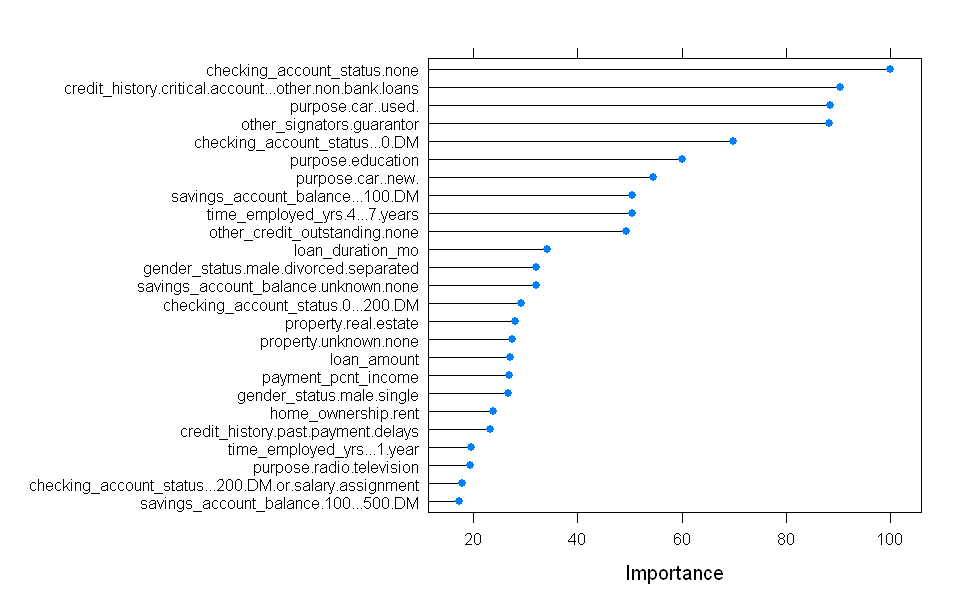

In [12]:
options(repr.plot.width=8, repr.plot.height=5)
plot(var_imp, top = 25)

Filtering by variable importance is a good way to find the features which should be pruned. The code in the cell below filters the variable importance using a threshold of 4.0. The code results are then displayed as a table, and the names are printed. Execute the code, examine the result, and answer **Question 2** on the course page.

****
**Note:** In practice you will need to try several threshold values to find a set of features where the model is not over-fit, but also has good performance. 
****

In [13]:
var_imp$importance$Imp = (var_imp$importance$Overall > 4.0)
var_imp$importance[var_imp$importance$Imp == TRUE,]
row.names(var_imp$importance[var_imp$importance$Imp == TRUE,])

,Overall,Imp
checking_account_status...0.DM,69.750767,TRUE
checking_account_status...200.DM.or.salary.assignment,17.847267,TRUE
checking_account_status.0...200.DM,29.101892,TRUE
checking_account_status.none,100.000000,TRUE
loan_duration_mo,34.216172,TRUE
credit_history.critical.account...other.non.bank.loans,90.414958,TRUE
credit_history.current.loans.paid,16.387969,TRUE
credit_history.past.payment.delays,23.226809,TRUE
purpose.business,4.238218,TRUE
purpose.car..new.,54.559196,TRUE


[1] "checking_account_status...0.DM"                        
 [2] "checking_account_status...200.DM.or.salary.assignment" 
 [3] "checking_account_status.0...200.DM"                    
 [4] "checking_account_status.none"                          
 [5] "loan_duration_mo"                                      
 [6] "credit_history.critical.account...other.non.bank.loans"
 [7] "credit_history.current.loans.paid"                     
 [8] "credit_history.past.payment.delays"                    
 [9] "purpose.business"                                      
[10] "purpose.car..new."                                     
[11] "purpose.car..used."                                    
[12] "purpose.education"                                     
[13] "purpose.radio.television"                              
[14] "loan_amount"                                           
[15] "savings_account_balance...100.DM"                      
[16] "savings_account_balance.100...500.DM"                  
[17] "savings_account_balance.unknown.none"                  
[18] "time_employed_yrs...1.year"                            
[19] "time_employed_yrs....7.years"                          
[20] "time_employed_yrs.4...7.years"                         
[21] "time_employed_yrs.unemployed"                          
[22] "payment_pcnt_income"                                   
[23] "gender_status.female.divorced.separated.married"       
[24] "gender_status.male.divorced.separated"                 
[25] "gender_status.male.single"                             
[26] "other_signators.guarantor"                             
[27] "other_signators.none"                                  
[28] "property.real.estate"                                  
[29] "property.unknown.none"                                 
[30] "age_yrs"                                               
[31] "other_credit_outstanding.bank"                         
[32] "other_credit_outstanding.none"                         
[33] "home_ownership.own"                                    
[34] "home_ownership.rent"                                   
[35] "number_loans"                                          
[36] "telephone.none"                                        
[37] "telephone.yes"

To continue this process you would test a model with these features. Further feature pruning can be performed based on feature importance of this next model. However, if model performance is significantly reduced, features will need to be added back to the model. 

## Summary

In this lab you have performed two types of feature selection:
1. Eliminating low variance features, which by their nature cannot be highly informative since they contain a high fraction of the same value.
2. Using feature importance to eliminate features which are not good predictors. 

Proper feature selection is key to creating machine learning models which will generalize well. 